In [ ]:
# Import project and set a symbolic link in /content

import os
from google.colab import drive
drive.mount('/content/gdrive')

# set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/bayesian-privacy'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/bayesian-privacy'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

## Move in the project directory
%cd /content/bayesian-privacy
!pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/bayesian-differential-privacy-master
/content/gdrive/My Drive/bayesian-differential-privacy-master


In [ ]:
import argparse
import itertools
import numpy as np
import pandas as pd
import os
import random
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.optim.optimizer import required
from torch.autograd import Variable
from torch.autograd import Function

from bayesian_privacy_accountant import BayesianPrivacyAccountant

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='mnist', help='mnist | cifar10 | svhn')
parser.add_argument('--dataroot', default='data', help='path to dataset')
parser.add_argument('--batchSize', type=int, default=1024, help='input batch size')
parser.add_argument('--imageSize', type=int, default=28, help='the height / width of the input image to network')
parser.add_argument('--nClasses', type=int, default=10, help='number of labels (classes)')
parser.add_argument('--nChannels', type=int, default=1, help='number of colour channels')
parser.add_argument('--ndf', type=int, default=64, help='number of filters in CNN')
parser.add_argument('--n_epochs', type=int, default=32, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate, default=0.0002')
parser.add_argument('--C', type=float, default=1.0, help='embedding L2-norm bound, default=1.0')
parser.add_argument('--sigma', type=float, default=0.1, help='noise variance, default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--outf', default='output', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, default=8664, help='manual seed for reproducibility')

opt, unknown = parser.parse_known_args()

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if torch.cuda.is_available():
    opt.cuda = True
    opt.ngpu = 1
    gpu_id = torch.cuda.current_device()
    print("Using CUDA: gpu_id = %d" % gpu_id)
    
if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)

Using CUDA: gpu_id = 0
Random Seed:  8664


In [ ]:
class View(nn.Module):
    """
        Implements a reshaping module.
        Allows to reshape a tensor between NN layers.
    """
    
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    
    def forward(self, input):
        return input.view(self.shape)

In [ ]:
filterSize = 5
w_out = 4
h_out = 4

class SimpleConvNet(nn.Module):
    
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(opt.nChannels, opt.ndf, filterSize),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(opt.ndf),
            nn.Conv2d(opt.ndf, opt.ndf, filterSize),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(opt.ndf),
            nn.MaxPool2d(2, 2),
            View(-1, opt.ndf * w_out * h_out),
            #PrintLayer("View"),
            #View(-1, 784),
            nn.Linear(opt.ndf * w_out * h_out, 384),
            nn.SELU(inplace=True),
            nn.Linear(384, 192),
            nn.SELU(inplace=True),
            nn.Linear(192, opt.nClasses),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
def test(testloader, net):
    """
        Compute test accuracy.
    """
    correct = 0.0
    total = 0.0
    
    '''
    if opt.cuda:
        net = net.cuda()
    '''
    
    for data in testloader:
        images, labels = data
        
        if opt.cuda:
            images = images.cuda(gpu_id)
            labels = labels.cuda(gpu_id)
            
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted.cpu().numpy())
        #print(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == (labels.long().view(-1) % 10)).sum()
        #print torch.cat([predicted.view(-1, 1), (labels.long() % 10)], dim=1)

    print('Accuracy of the network on test images: %f %%' % (100 * float(correct) / total))
    return 100 * float(correct) / total

In [ ]:
def sparsify_update(params, p, use_grad_field=True):
    init = True
    for param in params:
        if param is not None:
            if init:
                idx = torch.zeros_like(param, dtype=torch.bool)
                idx.bernoulli_(1 - p)
            if use_grad_field:
                if param.grad is not None:
                    idx = torch.zeros_like(param, dtype=torch.bool)
                    idx.bernoulli_(1 - p)
                    param.grad.data[idx] = 0
            else:
                init = False
                param.data[idx] = 0
    return idx

In [ ]:
def train(trainloader, student, n_epochs=25, lr=0.0001, accountant=None):
    criterion = nn.CrossEntropyLoss(reduction='none')
    #optimizer = optim.Adam(student.parameters(), lr=lr)
    optimizer = optim.SGD(student.parameters(), lr=lr)
    
    if opt.cuda:
        student = student.cuda(gpu_id)
        criterion = criterion.cuda(gpu_id)
    
    accuracies = []
    
    num_batches = len(trainloader.dataset) / opt.batchSize + 1
    sampling_prob = 0.1
    max_grad_norm = opt.C
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            
            if opt.cuda:
                inputs = inputs.cuda(gpu_id)
                labels = labels.cuda(gpu_id)
            
            inputv = Variable(inputs)
            labelv = Variable(labels.long().view(-1) % 10)
            
            batch_size = float(len(inputs))
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = student(inputv)
            loss = criterion(outputs, labelv)
            
            #max_grad_norm = opt.C * 0.9**epoch
            if accountant:
                grads_est = []
                num_subbatch = 8
                for j in range(num_subbatch):
                    grad_sample = torch.autograd.grad(
                        loss[np.delete(range(int(batch_size)), j)].mean(), 
                        [p for p in student.parameters() if p.requires_grad], 
                        retain_graph=True
                    )
                    with torch.no_grad():
                        grad_sample = torch.cat([g.view(-1) for g in grad_sample])
                        grad_sample /= max(1.0, grad_sample.norm().item() / max_grad_norm)
                        grads_est += [grad_sample]
                with torch.no_grad():
                    grads_est = torch.stack(grads_est)
                    sparsify_update(grads_est, p=sampling_prob, use_grad_field=False)
                
            (loss.mean()).backward()
            running_loss += loss.mean().item()
            
            if accountant:
                with torch.no_grad():
                    torch.nn.utils.clip_grad_norm_(student.parameters(), max_grad_norm)
                    for group in optimizer.param_groups:
                        for p in group['params']:
                            if p.grad is not None:
                                p.grad += torch.randn_like(p.grad) * (opt.sigma * max_grad_norm)
                    sparsify_update(student.parameters(), p=sampling_prob)
                
            optimizer.step()
            
            if accountant:
                with torch.no_grad():
                    batch_size = float(len(inputs))
                    q = batch_size / len(trainloader.dataset)
                    # NOTE: 
                    # Using combinations within a set of gradients (like below)
                    # does not actually produce samples from the correct distribution
                    # (for that, we need to sample pairs of gradients independently).
                    # However, the difference is not significant, and it speeds up computations.
                    pairs = list(zip(*itertools.combinations(grads_est, 2)))
                    accountant.accumulate(
                        ldistr=(torch.stack(pairs[0]), opt.sigma*max_grad_norm),
                        rdistr=(torch.stack(pairs[1]), opt.sigma*max_grad_norm),
                        q=q, 
                        steps=1,
                    )
            
        # print training stats every epoch
        running_eps = accountant.get_privacy(target_delta=1e-5) if accountant else None
        print("Epoch: %d/%d. Loss: %.3f. Privacy (𝜀,𝛿): %s" %
              (epoch + 1, n_epochs, running_loss / len(trainloader), running_eps))
                
        acc = test(testloader, student)
        accuracies += [acc]
        print("Test accuracy is %d %%" % acc)

    print('Finished Training')
    return student.cpu(), accuracies

In [ ]:
# transformations applied to data
transform = transforms.Compose([transforms.ToTensor()])

# switch datasets
if opt.dataset == 'mnist':
    trainset = torchvision.datasets.MNIST(root=opt.dataroot + os.sep + opt.dataset, train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root=opt.dataroot + os.sep + opt.dataset, train=False, download=True, transform=transform)
elif opt.dataset == 'cifar10':
    trainset = torchvision.datasets.CIFAR10(root=opt.dataroot + os.sep + opt.dataset, train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root=opt.dataroot + os.sep + opt.dataset, train=False, download=True, transform=transform)
elif opt.dataset == 'svhn':
    trainset = torchvision.datasets.SVHN(root=opt.dataroot + os.sep + opt.dataset, split='train', download=True, transform=transform)
    testset = torchvision.datasets.SVHN(root=opt.dataroot + os.sep + opt.dataset, split='test', download=True, transform=transform)

#val_size = 10000
#valset = torch.utils.data.Subset(trainset, range(val_size))
#trainset = torch.utils.data.Subset(trainset, range(val_size, len(trainset)))
    
# initialise data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=opt.batchSize, shuffle=True, num_workers=2, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=opt.batchSize, shuffle=True, num_workers=2)

# names of classes
classes = tuple(np.arange(10).astype(str))

In [ ]:
# train and test
netS = SimpleConvNet()
total_steps = opt.n_epochs * len(trainloader)
bayes_accountant = BayesianPrivacyAccountant(powers=[2, 4, 8, 16, 32], total_steps=total_steps)
netS, accs = train(trainloader, netS, lr=0.02, n_epochs=opt.n_epochs, accountant=bayes_accountant)

Epoch: 1/32. Loss: 2.153. Privacy (𝜀,𝛿): (0.3603139622317727, 1e-05)
Accuracy of the network on test images: 46.720000 %
Test accuracy is 46 %
Epoch: 2/32. Loss: 1.797. Privacy (𝜀,𝛿): (0.36099711163368264, 1e-05)
Accuracy of the network on test images: 70.270000 %
Test accuracy is 70 %
Epoch: 3/32. Loss: 1.511. Privacy (𝜀,𝛿): (0.3618431923277266, 1e-05)
Accuracy of the network on test images: 78.320000 %
Test accuracy is 78 %
Epoch: 4/32. Loss: 1.286. Privacy (𝜀,𝛿): (0.36288609873518374, 1e-05)
Accuracy of the network on test images: 83.190000 %
Test accuracy is 83 %
Epoch: 5/32. Loss: 1.094. Privacy (𝜀,𝛿): (0.3641397125430758, 1e-05)
Accuracy of the network on test images: 85.650000 %
Test accuracy is 85 %
Epoch: 6/32. Loss: 0.921. Privacy (𝜀,𝛿): (0.3655912125048158, 1e-05)
Accuracy of the network on test images: 88.030000 %
Test accuracy is 88 %
Epoch: 7/32. Loss: 0.775. Privacy (𝜀,𝛿): (0.36756126237951814, 1e-05)
Accuracy of the network on test images: 89.390000 %
Test accuracy is 8

In [ ]:
print("Bayesian DP (𝜀,𝛿): ", bayes_accountant.get_privacy(target_delta=1e-10))

Bayesian DP (𝜀,𝛿):  (0.8782959776431745, 1e-10)


In [ ]:
from scipy.spatial.distance import pdist

sampling_prob = 0.1
loss_fn = nn.CrossEntropyLoss(reduction='none')

netS.cuda(gpu_id)
loss_fn.cuda(gpu_id)

dists_train = []
dists_test = []

i = 0
for inputs, labels in trainloader:
    i += 1
    if i > 8:
        break
    inputs = inputs.cuda(gpu_id)
    labels = labels.cuda(gpu_id)
    netS.zero_grad()
    outputs = netS(inputs)
    loss = loss_fn(outputs, labels)
    
    grads_est = []
    num_subbatch = 100
    for j in range(num_subbatch):
        grad_sample = torch.autograd.grad(loss[np.delete(range(int(opt.batchSize)), j)].mean(), [p for p in netS.parameters() if p.requires_grad], retain_graph=True)
        with torch.no_grad():
            grad_sample = torch.cat([g.view(-1) for g in grad_sample])
            grad_sample /= max(1.0, grad_sample.norm().item() / opt.C)
            grads_est += [grad_sample]
    with torch.no_grad():
        grads_est = torch.stack(grads_est)
        sparsify_update(grads_est, p=sampling_prob, use_grad_field=False)
    q = opt.batchSize / len(trainloader.dataset)
    dists_train += [pdist(grads_est.cpu())]
    
i = 0
for inputs, labels in testloader:
    i += 1
    if i > 8:
        break
    inputs = inputs.cuda(gpu_id)
    labels = labels.cuda(gpu_id)
    netS.zero_grad()
    outputs = netS(inputs)
    loss = loss_fn(outputs, labels)
    
    grads_est = []
    num_subbatch = 100
    for j in range(num_subbatch):
        grad_sample = torch.autograd.grad(loss[np.delete(range(int(opt.batchSize)), j)].mean(), [p for p in netS.parameters() if p.requires_grad], retain_graph=True)
        with torch.no_grad():
            grad_sample = torch.cat([g.view(-1) for g in grad_sample])
            grad_sample /= max(1.0, grad_sample.norm().item() / opt.C)
            grads_est += [grad_sample]
    with torch.no_grad():
        grads_est = torch.stack(grads_est)
        sparsify_update(grads_est, p=sampling_prob, use_grad_field=False)
    q = opt.batchSize / len(trainloader.dataset)
    dists_test += [pdist(grads_est.cpu())]

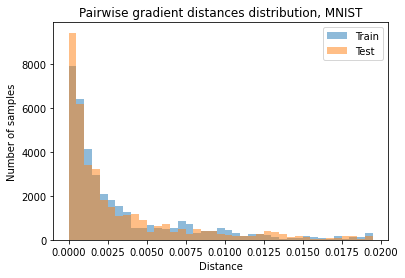

In [ ]:
from scipy.stats import ks_2samp, ttest_rel

dists_train = np.stack(dists_train).squeeze()
dists_test = np.stack(dists_test).squeeze()

plt.hist(dists_train.flatten(), bins=np.arange(0, 0.02, 0.0005), label='Train', alpha=0.5)
plt.hist(dists_test.flatten(), bins=np.arange(0, 0.02, 0.0005), label='Test', alpha=0.5)
plt.legend()
plt.xlabel(r'Distance')
plt.ylabel(r'Number of samples')
plt.title(r'Pairwise gradient distances distribution, MNIST')
plt.savefig('grad_dist_histogram_mnist_2.pdf', format='pdf', bbox_inches='tight')

In [ ]:
from scipy.stats import ttest_rel, ttest_ind, levene

print(ttest_rel(dists_train.flatten(), dists_test.flatten()))
print(ttest_ind(dists_train.flatten(), dists_test.flatten()))
print(levene(dists_train.flatten(), dists_test.flatten()))

TtestResult(statistic=-2.2856676055972476, pvalue=0.022278970451873496, df=39599)
Ttest_indResult(statistic=-2.2427026467582456, pvalue=0.024918750414032582)
LeveneResult(statistic=20.801336716617335, pvalue=5.10235986310505e-06)
